In [1]:
import os
import time
from datetime import datetime

import numpy as np
import pandas as pd
import scipy as sp
from tqdm import tqdm

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
# x = tf.compat.v1.placeholder(tf.float64, shape=[None])

# with tf.compat.v1.Session() as sess:

#     #writer = tf.summary.create_file_writer(logdir)

#     #tf.profiler.experimental.start(logdir, options = options)                                                                                                                                
#     #tf.summary.trace_on(graph=True, profiler=True)

#     print(
#         sess.run(
#             f1(c1),
# #             feed_dict={
# #                 x: np.ones(4, dtype=np.int)
# #             }
#         )
#     )

# #f1(c1)

In [5]:
def variance_weighted_result(means, stddevs):
    """ Computes weighted mean and stddev of given means and
        stddevs arrays, using Inverse-variance weighting
    """
    assert np.size(means) == np.size(stddevs)
    assert means.shape == stddevs.shape
    variance = 1./np.sum(1./stddevs**2, axis=-1)
    mean = np.sum(means/(stddevs**2), axis=-1)
    mean *= variance
    return mean, np.sqrt(variance)

In [6]:
NRUNS = 7

### F1 - simple gauss

In [170]:
import scipy.stats as spt

target = 1
target_precision = 1e-3

norm_dist = spt.norm(loc=0.5, scale=0.05)

{
    'f1_d2': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 2,
    'f1_d4': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 4,
    'f1_d6': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 6,
    'f1_d8': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 8,
}

{'f1_d2': 1.0, 'f1_d4': 1.0, 'f1_d6': 1.0, 'f1_d8': 1.0}

In [171]:
sigma = 0.05
alpha = sigma * np.sqrt(2)
alpha_tf = tf.constant(alpha, dtype=tf.float64)
pi = np.pi
pi_sqrt_tf = tf.constant(np.pi, dtype=tf.float64)


@tf.function(input_signature=[tf.TensorSpec(shape=(None,2), dtype=tf.float64)])
def f1_d2(x):
    pre = tf.cast(1.0 / (alpha * pi_sqrt_tf) ** 2, dtype=tf.float64)
    exponent = -1 * tf.reduce_sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)

def f1_d2_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** 2
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)


@tf.function(input_signature=[tf.TensorSpec(shape=(None,4), dtype=tf.float64)])
def f1_d4(x):
    pre = tf.cast(1.0 / (alpha * pi_sqrt_tf) ** 4, dtype=tf.float64)
    exponent = -1 * tf.reduce_sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)


@tf.function(input_signature=[tf.TensorSpec(shape=(None,6), dtype=tf.float64)])
def f1_d6(x):
    pre = tf.cast(1.0 / (alpha * pi_sqrt_tf) ** 6, dtype=tf.float64)
    exponent = -1 * tf.reduce_sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)


@tf.function(input_signature=[tf.TensorSpec(shape=(None,8), dtype=tf.float64)])
def f1_d8(x):
    pre = tf.cast(1.0 / (alpha * pi_sqrt_tf) ** 8, dtype=tf.float64)
    exponent = -1 * tf.reduce_sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)

In [172]:
dim2func_dict = {
    2: f1_d2,
    4: f1_d4,
    6: f1_d6,
    8: f1_d8,
}
dim2func_dict

{2: <tensorflow.python.eager.def_function.Function at 0x17880518888>,
 4: <tensorflow.python.eager.def_function.Function at 0x1788040ff88>,
 6: <tensorflow.python.eager.def_function.Function at 0x17880518248>,
 8: <tensorflow.python.eager.def_function.Function at 0x17880003c88>}

#### Uniform

In [10]:
%%time
tf.random.set_seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [1e5, 1e6, 1e7]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand = dim2func_dict[ndims]
        for neval in neval_lst:

            print(f'ndims={ndims}  nitn={neval}')

            time_a = time.time()
            data = tf.random.uniform(shape=(neval, ndims), minval=0, maxval=1, dtype=tf.float64)
            gen_time = time.time() - time_a
            
            time_a = time.time()
            current_result = integrand(data)
            current_result_mean = tf.reduce_mean(current_result)
            current_result_sdev = tf.math.reduce_std(current_result) / np.sqrt(ndims)
            eval_time = time.time() - time_a
            
            result_means.append(current_result_mean.numpy())
            result_sdevs.append(current_result_sdev.numpy())
            result_gen_times.append(gen_time)
            result_eval_times.append(eval_time)
            result_run_nums.append(run)
            
            # print(current_result_mean, current_result_stddev)

run=1
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=2  nitn=10000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=4  nitn=10000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=6  nitn=10000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
ndims=8  nitn=10000000
run=2
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=2  nitn=10000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=4  nitn=10000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=6  nitn=10000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
ndims=8  nitn=10000000
run=3
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=2  nitn=10000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=4  nitn=10000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=6  nitn=10000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
ndims=8  nitn=10000000
run=4
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=2  nitn=10000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=4  nitn=10000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=6  

In [11]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst) * len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
    # 'batch_num': result_jbatch
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)

In [12]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,eval_time_perc
0,2,100000,0.303848,1.212737,0.002992,0.075797,1,0.96
1,2,1000000,0.320706,1.252406,0.013963,0.012965,1,0.48
2,2,10000000,0.318726,1.250506,0.169547,0.121674,1,0.42
3,4,100000,0.111069,1.695581,0.017952,0.063829,1,0.78
4,4,1000000,0.101714,1.608891,0.032913,0.016953,1,0.34
...,...,...,...,...,...,...,...,...
79,6,1000000,0.031791,2.402522,0.047872,0.018950,7,0.28
80,6,10000000,0.030991,2.275132,0.500660,0.201461,7,0.29
81,8,100000,0.000850,0.074262,0.042886,0.008976,7,0.17
82,8,1000000,0.004164,0.566030,0.063829,0.021941,7,0.26


In [13]:
temp_df.to_csv('result/02_Baseline_LDSeq/f1_uniform.csv', index=False)

In [14]:
# pd.read_csv('result/02_Baseline_LDSeq/f1_uniform.csv')

In [15]:
g_temp_df = temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'eval_time_perc']]

In [16]:
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,eval_time_perc
0,2,100000,0.316534,1.246475,0.044025,0.017667,0.257143
1,2,1000000,0.319649,1.253395,0.015672,0.011683,0.425714
2,2,10000000,0.318325,1.249865,0.171826,0.117687,0.408571
3,4,100000,0.104832,1.626104,0.016241,0.016670,0.417143
4,4,1000000,0.103036,1.636447,0.033482,0.015815,0.321429
5,4,10000000,0.101135,1.609308,0.334819,0.155014,0.315714
6,6,100000,0.022475,1.225374,0.031060,0.016385,0.290000
7,6,1000000,0.029752,2.172886,0.049581,0.019377,0.278571
8,6,10000000,0.032632,2.394512,0.501373,0.194622,0.280000
9,8,100000,0.003645,0.298915,0.046590,0.016527,0.221429


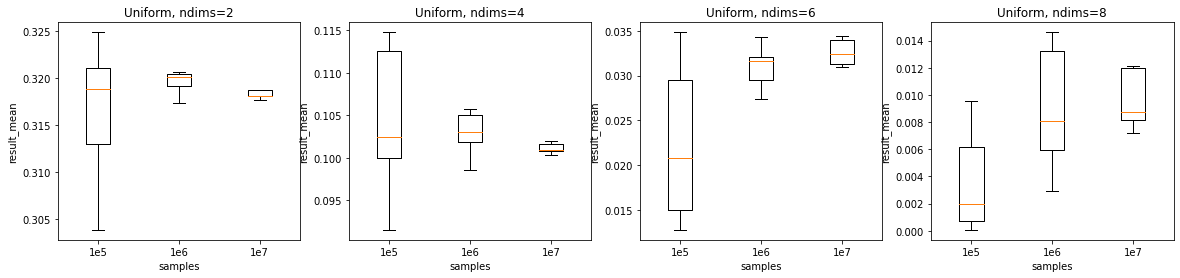

In [17]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    # ax.axhline(y=target, linestyle=':')
    ax.set_title(f'Uniform, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6', '1e7'], showfliers=False)

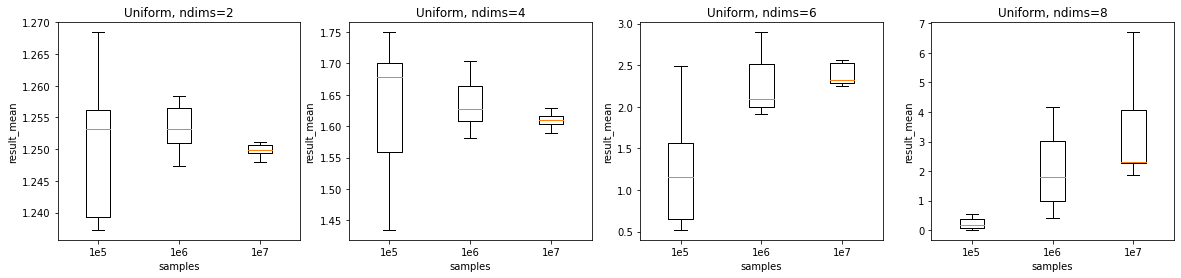

In [18]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Uniform, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6', '1e7'], showfliers=False)

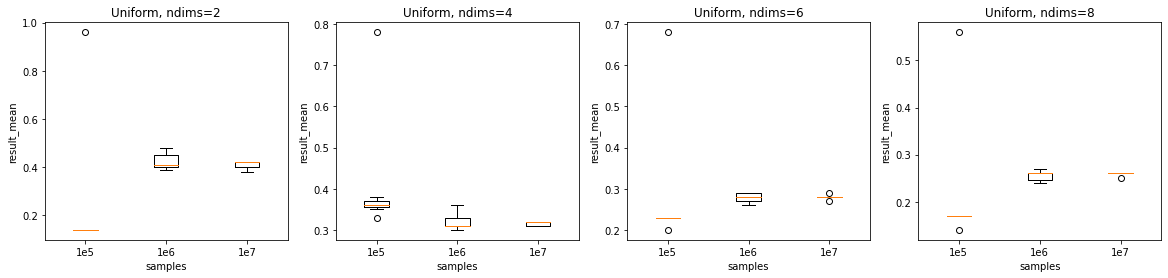

In [19]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Uniform, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6', '1e7'], showfliers=None)

#### Halton

##### simple

In [20]:
%%time
tf.random.set_seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [1e5, 1e6]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand = dim2func_dict[ndims]
        for neval in neval_lst:

            print(f'ndims={ndims}  nitn={neval}')

            time_a = time.time()
            data = tfp.mcmc.sample_halton_sequence(
                dim=ndims,
                #sequence_indices=sequence_indices,
                num_results=neval,
                dtype=tf.float64,
                randomized=True,
                seed=run
            )
            gen_time = time.time() - time_a
            
            time_a = time.time()
            current_result = integrand(data)
            current_result_mean = tf.reduce_mean(current_result)
            current_result_sdev = tf.math.reduce_std(current_result) / np.sqrt(ndims)
            eval_time = time.time() - time_a
            
            result_means.append(current_result_mean.numpy())
            result_sdevs.append(current_result_sdev.numpy())
            result_gen_times.append(gen_time)
            result_eval_times.append(eval_time)
            result_run_nums.append(run)
            
            # print(current_result_mean, current_result_stddev)

run=1
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=2
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=3
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=4
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=5
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=6
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=1000

In [21]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst) * len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
    # 'batch_num': result_jbatch
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)

In [22]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,eval_time_perc
0,2,100000,0.318350,1.249846,0.130651,0.012965,1,0.09
1,2,1000000,0.318314,1.249812,0.776922,0.011967,1,0.02
2,4,100000,0.101328,1.648117,0.132646,0.006981,1,0.05
3,4,1000000,0.100769,1.600235,1.581770,0.016955,1,0.01
4,6,100000,0.024961,1.752365,0.214427,0.007978,1,0.04
5,6,1000000,0.032726,2.337773,2.419530,0.020944,1,0.01
6,8,100000,0.001506,0.103925,0.296208,0.008976,1,0.03
7,8,1000000,0.003417,0.455629,3.242330,0.023936,1,0.01
8,2,100000,0.318340,1.250062,0.071809,0.001994,2,0.03
9,2,1000000,0.318289,1.249709,0.767946,0.010970,2,0.01


In [23]:
temp_df.to_csv('result/02_Baseline_LDSeq/f1_halton_simple.csv', index=False)

In [24]:
# pd.read_csv('result/02_Baseline_LDSeq/f1_halton_simple.csv')

In [25]:
g_temp_df = temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'eval_time_perc']]

In [26]:
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,eval_time_perc
0,2,100000,0.318221,1.249512,0.081354,0.003847,0.041429
1,2,1000000,0.318309,1.249777,0.773645,0.011683,0.017143
2,4,100000,0.101454,1.589851,0.141337,0.002707,0.015714
3,4,1000000,0.101157,1.608100,1.588894,0.015815,0.010000
4,6,100000,0.034754,2.298878,0.216991,0.003990,0.017143
5,6,1000000,0.032459,2.436463,2.422094,0.019377,0.010000
6,8,100000,0.003971,0.275808,0.286377,0.004274,0.012857
7,8,1000000,0.006313,0.996849,3.253870,0.023224,0.010000


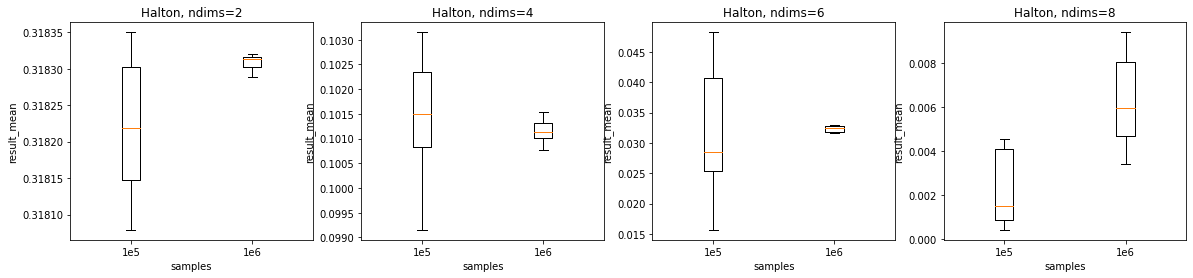

In [27]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    # ax.axhline(y=target, linestyle=':')
    ax.set_title(f'Halton, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=False)

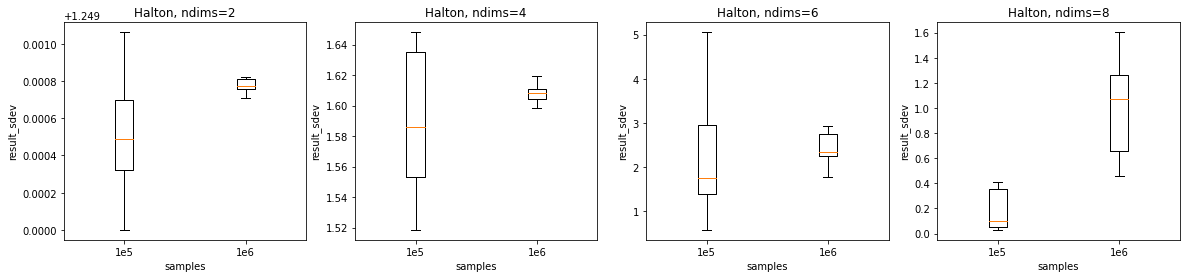

In [28]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Halton, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_sdev')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=False)

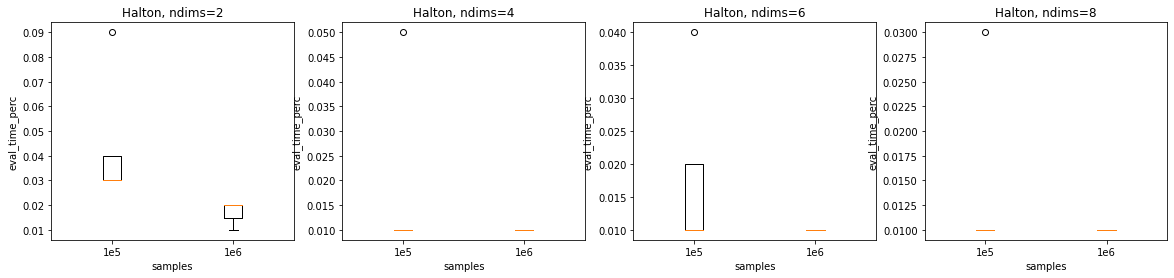

In [29]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Halton, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('eval_time_perc')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=None)

##### batch (kind of)

In [30]:
%%time
tf.random.set_seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []
result_jbatch = []

nbatch = 10
ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [1e6, 1e7]))
neval_on_batch = [x // nbatch for x in neval_lst]
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand = dim2func_dict[ndims]
        for i_eval, neval in enumerate(neval_lst):

            for j_batch in range(nbatch):
                print(f'ndims={ndims}  neval={neval}  j_batch={j_batch}')

                time_a = time.time()
                data = tfp.mcmc.sample_halton_sequence(
                    dim=ndims,
                    sequence_indices=tf.range(start=j_batch*neval_on_batch[i_eval],
                                              limit=(j_batch+1)*neval_on_batch[i_eval],
                                              dtype=tf.int32),
                    # num_results=nitn,
                    dtype=tf.float64,
                    randomized=True,
                    seed=run
                )
                gen_time = time.time() - time_a

                time_a = time.time()
                current_result = integrand(data)
                current_result_mean = tf.reduce_mean(current_result)
                current_result_sdev = tf.math.reduce_std(current_result) / np.sqrt(ndims)
                eval_time = time.time() - time_a

                result_means.append(current_result_mean.numpy())
                result_sdevs.append(current_result_sdev.numpy())
                result_gen_times.append(gen_time)
                result_eval_times.append(eval_time)
                result_run_nums.append(run)
                
                result_jbatch.append(j_batch)

                # print(current_result_mean, current_result_stddev)

run=1
ndims=2  neval=1000000  j_batch=0
ndims=2  neval=1000000  j_batch=1
ndims=2  neval=1000000  j_batch=2
ndims=2  neval=1000000  j_batch=3
ndims=2  neval=1000000  j_batch=4
ndims=2  neval=1000000  j_batch=5
ndims=2  neval=1000000  j_batch=6
ndims=2  neval=1000000  j_batch=7
ndims=2  neval=1000000  j_batch=8
ndims=2  neval=1000000  j_batch=9
ndims=2  neval=10000000  j_batch=0
ndims=2  neval=10000000  j_batch=1
ndims=2  neval=10000000  j_batch=2
ndims=2  neval=10000000  j_batch=3
ndims=2  neval=10000000  j_batch=4
ndims=2  neval=10000000  j_batch=5
ndims=2  neval=10000000  j_batch=6
ndims=2  neval=10000000  j_batch=7
ndims=2  neval=10000000  j_batch=8
ndims=2  neval=10000000  j_batch=9
ndims=4  neval=1000000  j_batch=0
ndims=4  neval=1000000  j_batch=1
ndims=4  neval=1000000  j_batch=2
ndims=4  neval=1000000  j_batch=3
ndims=4  neval=1000000  j_batch=4
ndims=4  neval=1000000  j_batch=5
ndims=4  neval=1000000  j_batch=6
ndims=4  neval=1000000  j_batch=7
ndims=4  neval=1000000  j_batch=

ndims=8  neval=10000000  j_batch=7
ndims=8  neval=10000000  j_batch=8
ndims=8  neval=10000000  j_batch=9
run=4
ndims=2  neval=1000000  j_batch=0
ndims=2  neval=1000000  j_batch=1
ndims=2  neval=1000000  j_batch=2
ndims=2  neval=1000000  j_batch=3
ndims=2  neval=1000000  j_batch=4
ndims=2  neval=1000000  j_batch=5
ndims=2  neval=1000000  j_batch=6
ndims=2  neval=1000000  j_batch=7
ndims=2  neval=1000000  j_batch=8
ndims=2  neval=1000000  j_batch=9
ndims=2  neval=10000000  j_batch=0
ndims=2  neval=10000000  j_batch=1
ndims=2  neval=10000000  j_batch=2
ndims=2  neval=10000000  j_batch=3
ndims=2  neval=10000000  j_batch=4
ndims=2  neval=10000000  j_batch=5
ndims=2  neval=10000000  j_batch=6
ndims=2  neval=10000000  j_batch=7
ndims=2  neval=10000000  j_batch=8
ndims=2  neval=10000000  j_batch=9
ndims=4  neval=1000000  j_batch=0
ndims=4  neval=1000000  j_batch=1
ndims=4  neval=1000000  j_batch=2
ndims=4  neval=1000000  j_batch=3
ndims=4  neval=1000000  j_batch=4
ndims=4  neval=1000000  j_bat

ndims=8  neval=10000000  j_batch=4
ndims=8  neval=10000000  j_batch=5
ndims=8  neval=10000000  j_batch=6
ndims=8  neval=10000000  j_batch=7
ndims=8  neval=10000000  j_batch=8
ndims=8  neval=10000000  j_batch=9
run=7
ndims=2  neval=1000000  j_batch=0
ndims=2  neval=1000000  j_batch=1
ndims=2  neval=1000000  j_batch=2
ndims=2  neval=1000000  j_batch=3
ndims=2  neval=1000000  j_batch=4
ndims=2  neval=1000000  j_batch=5
ndims=2  neval=1000000  j_batch=6
ndims=2  neval=1000000  j_batch=7
ndims=2  neval=1000000  j_batch=8
ndims=2  neval=1000000  j_batch=9
ndims=2  neval=10000000  j_batch=0
ndims=2  neval=10000000  j_batch=1
ndims=2  neval=10000000  j_batch=2
ndims=2  neval=10000000  j_batch=3
ndims=2  neval=10000000  j_batch=4
ndims=2  neval=10000000  j_batch=5
ndims=2  neval=10000000  j_batch=6
ndims=2  neval=10000000  j_batch=7
ndims=2  neval=10000000  j_batch=8
ndims=2  neval=10000000  j_batch=9
ndims=4  neval=1000000  j_batch=0
ndims=4  neval=1000000  j_batch=1
ndims=4  neval=1000000  j_

In [31]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * nbatch * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst * nbatch)* len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
    'batch_num': result_jbatch
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)

In [32]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,batch_num,eval_time_perc
0,2,1000000,0.318350,1.249846,0.080784,0.006981,1,0,0.08
1,2,1000000,0.318495,1.250230,0.073803,0.000998,1,1,0.01
2,2,1000000,0.318490,1.250344,0.081781,0.000997,1,2,0.01
3,2,1000000,0.318252,1.249431,0.079787,0.001994,1,3,0.02
4,2,1000000,0.318260,1.249536,0.079787,0.001995,1,4,0.02
...,...,...,...,...,...,...,...,...,...
555,8,10000000,0.005601,0.975276,3.667194,0.022938,7,5,0.01
556,8,10000000,0.024326,5.663952,3.692128,0.023935,7,6,0.01
557,8,10000000,0.002208,0.259752,3.675172,0.022939,7,7,0.01
558,8,10000000,0.004013,0.668914,3.892591,0.025931,7,8,0.01


In [33]:
temp_df.to_csv('result/02_Baseline_LDSeq/f1_halton_batch.csv', index=False)

In [34]:
# pd.read_csv('result/02_Baseline_LDSeq/f1_halton_batch.csv')

In [35]:
# mean over batches
g_temp_df = temp_df.groupby(['ndims', 'neval', 'run_num'], as_index=False).agg(np.mean)

# mean over runs
g_temp_df = g_temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'eval_time_perc']]
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,eval_time_perc
0,2,1000000,0.318283,1.249671,0.077977,0.001653,0.019857
1,2,10000000,0.318309,1.249766,0.858291,0.012395,0.012429
2,4,1000000,0.101343,1.608521,0.158461,0.002024,0.010571
3,4,10000000,0.101323,1.611354,1.771990,0.016513,0.010000
4,6,1000000,0.030532,1.892413,0.240556,0.002694,0.011429
5,6,10000000,0.031941,2.276405,2.689959,0.020303,0.010000
6,8,1000000,0.005473,0.498916,0.320416,0.002920,0.010286
7,8,10000000,0.010280,2.331427,3.618111,0.024050,0.010000


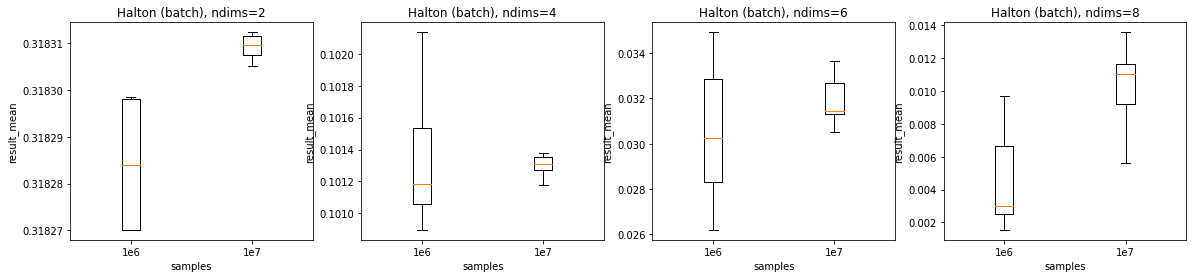

In [36]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims]\
        .groupby(['neval', 'run_num'], as_index=False).agg(np.mean)\
        .groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    # ax.axhline(y=target, linestyle=':')
    ax.set_title(f'Halton (batch), ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e6', '1e7'], showfliers=False)

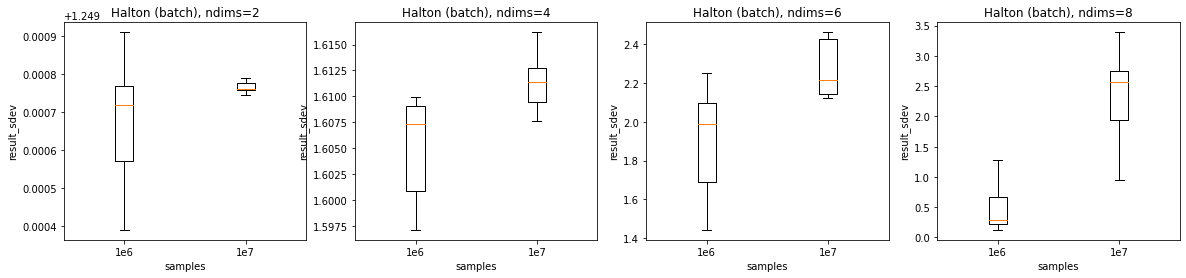

In [37]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims]\
        .groupby(['neval', 'run_num'], as_index=False).agg(np.mean)\
        .groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Halton (batch), ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_sdev')
    ax.boxplot(plot_data, labels=['1e6', '1e7'], showfliers=False)

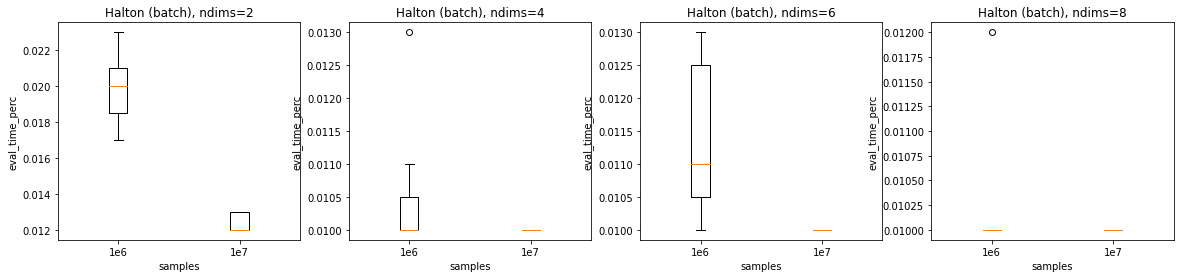

In [38]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims]\
        .groupby(['neval', 'run_num'], as_index=False).agg(np.mean)\
        .groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Halton (batch), ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('eval_time_perc')
    ax.boxplot(plot_data, labels=['1e6', '1e7'], showfliers=None)

#### Sobol

##### simple

In [39]:
%%time
tf.random.set_seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [1e5, 1e6]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand = dim2func_dict[ndims]
        for neval in neval_lst:

            print(f'ndims={ndims}  nitn={neval}')

            time_a = time.time()
            data = tf.math.sobol_sample(
                dim=ndims,
                num_results=neval,
                # skip=j*neval,
                dtype=tf.dtypes.float64,
                #name=None
            )
            gen_time = time.time() - time_a
            
            time_a = time.time()
            current_result = integrand(data)
            current_result_mean = tf.reduce_mean(current_result)
            current_result_sdev = tf.math.reduce_std(current_result) / np.sqrt(ndims)
            eval_time = time.time() - time_a
            
            result_means.append(current_result_mean.numpy())
            result_sdevs.append(current_result_sdev.numpy())
            result_gen_times.append(gen_time)
            result_eval_times.append(eval_time)
            result_run_nums.append(run)
            
            # print(current_result_mean, current_result_stddev)

run=1
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=2
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=3
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=4
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=5
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=6
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=1000

In [40]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst) * len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
    #'batch_num': result_jbatch
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)

In [41]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,eval_time_perc
0,2,100000,0.317968,1.248881,0.007978,0.007978,1,0.50
1,2,1000000,0.318265,1.249579,0.002992,0.010971,1,0.79
2,4,100000,0.109602,1.832634,0.001995,0.007978,1,0.80
3,4,1000000,0.101922,1.630288,0.004987,0.017953,1,0.78
4,6,100000,0.110745,10.917419,0.002991,0.007979,1,0.73
5,6,1000000,0.036186,3.783637,0.005984,0.020944,1,0.78
6,8,100000,1.688022,188.527168,0.004986,0.007980,1,0.62
7,8,1000000,0.170922,59.618630,0.008975,0.025931,1,0.74
8,2,100000,0.317968,1.248881,0.005985,0.002991,2,0.33
9,2,1000000,0.318265,1.249579,0.002992,0.011969,2,0.80


In [42]:
temp_df.to_csv('result/02_Baseline_LDSeq/f1_sobol_simple.csv', index=False)

In [43]:
# pd.read_csv('result/02_Baseline_LDSeq/f1_sobol_simple.csv')

In [44]:
g_temp_df = temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'eval_time_perc']]

In [45]:
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,eval_time_perc
0,2,100000,0.317968,1.248881,0.006126,0.002992,0.302857
1,2,1000000,0.318265,1.249579,0.002565,0.011683,0.822857
2,4,100000,0.109602,1.832634,0.001852,0.003562,0.635714
3,4,1000000,0.101922,1.630288,0.004417,0.016385,0.788571
4,6,100000,0.110745,10.917419,0.003277,0.003847,0.522857
5,6,1000000,0.036186,3.783637,0.006411,0.021229,0.768571
6,8,100000,1.688022,188.527168,0.004559,0.004417,0.481429
7,8,1000000,0.170922,59.618630,0.008975,0.024791,0.735714


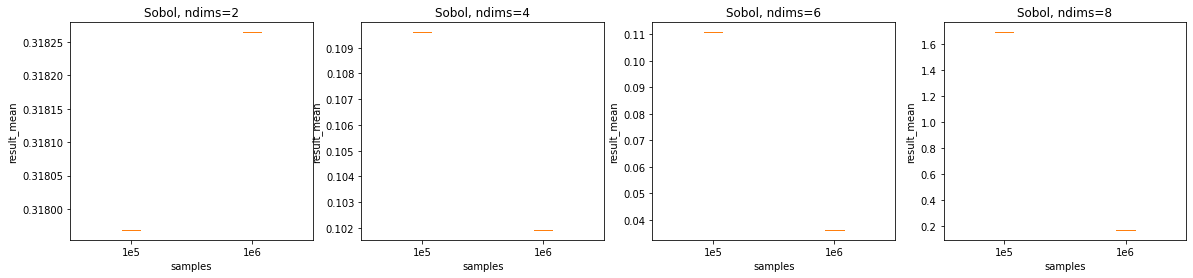

In [46]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    # ax.axhline(y=target, linestyle=':')
    ax.set_title(f'Sobol, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=False)

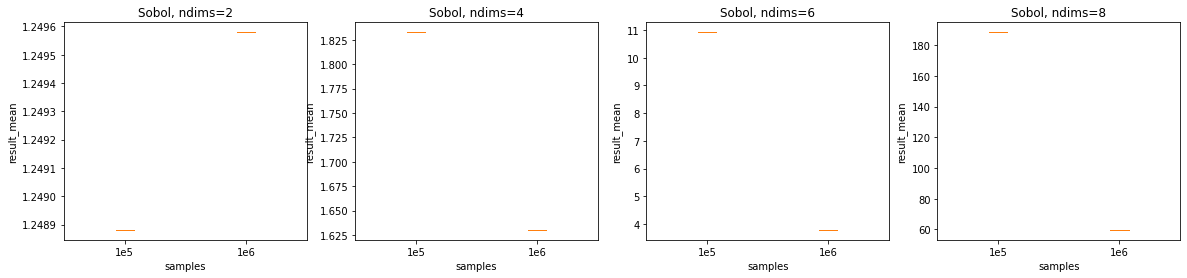

In [47]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Sobol, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=False)

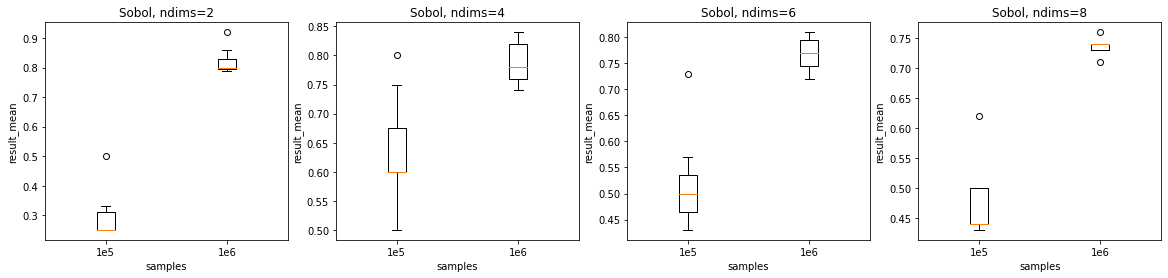

In [48]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Sobol, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=None)

### F2 - triple gauss

In [49]:
import scipy.stats as spt

norm_m1, norm_m2, norm_m3 = 0.33, 0.47, 0.67

norm_dist_1 = spt.norm(loc=norm_m1, scale=0.05)
norm_dist_2 = spt.norm(loc=norm_m2, scale=0.05)
norm_dist_3 = spt.norm(loc=norm_m3, scale=0.05)
# norm_dist = (norm_dist_1 + norm_dist_2 + norm_dist_3) / 3

norm_triple = norm_dist_1.cdf(1) - norm_dist_1.cdf(0) \
            + norm_dist_2.cdf(1) - norm_dist_2.cdf(0) \
            + norm_dist_3.cdf(1) - norm_dist_3.cdf(0)
norm_triple /= 3

{
    'f2_d2': norm_triple ** 2,
    'f2_d4': norm_triple ** 4,
    'f2_d6': norm_triple ** 6,
    'f2_d8': norm_triple ** 8,
}

{'f2_d2': 0.9999999999725897,
 'f2_d4': 0.9999999999451794,
 'f2_d6': 0.9999999999177691,
 'f2_d8': 0.9999999998903588}

In [50]:
sigma = 0.05
alpha = sigma * np.sqrt(2)
alpha_tf = tf.constant(alpha, dtype=tf.float64)
pi = np.pi
pi_sqrt_tf = tf.constant(np.pi, dtype=tf.float64)


@tf.function(input_signature=[tf.TensorSpec(shape=(None,2), dtype=tf.float64)])
def f2_d2(x):
    pre = tf.cast(1. / (alpha * pi_sqrt_tf) ** 2, dtype=tf.float64)
    exponent1 = -1. * tf.reduce_sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * tf.reduce_sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * tf.reduce_sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (tf.exp(exponent1) + tf.exp(exponent2) + tf.exp(exponent3))


def f2_d2_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 2
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))


@tf.function(input_signature=[tf.TensorSpec(shape=(None,4), dtype=tf.float64)])
def f2_d4(x):
    pre = tf.cast(1. / (alpha * pi_sqrt_tf) ** 4, dtype=tf.float64)
    exponent1 = -1. * tf.reduce_sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * tf.reduce_sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * tf.reduce_sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (tf.exp(exponent1) + tf.exp(exponent2) + tf.exp(exponent3))


@tf.function(input_signature=[tf.TensorSpec(shape=(None,6), dtype=tf.float64)])
def f2_d6(x):
    pre = tf.cast(1. / (alpha * pi_sqrt_tf) ** 6, dtype=tf.float64)
    exponent1 = -1. * tf.reduce_sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * tf.reduce_sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * tf.reduce_sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (tf.exp(exponent1) + tf.exp(exponent2) + tf.exp(exponent3))


@tf.function(input_signature=[tf.TensorSpec(shape=(None,8), dtype=tf.float64)])
def f2_d8(x):
    pre = tf.cast(1. / (alpha * pi_sqrt_tf) ** 8, dtype=tf.float64)
    exponent1 = -1. * tf.reduce_sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * tf.reduce_sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * tf.reduce_sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (tf.exp(exponent1) + tf.exp(exponent2) + tf.exp(exponent3))

In [51]:
dim2func_dict = {
    2: f2_d2,
    4: f2_d4,
    6: f2_d6,
    8: f2_d8,
}
dim2func_dict

{2: <tensorflow.python.eager.def_function.Function at 0x178cfdba108>,
 4: <tensorflow.python.eager.def_function.Function at 0x178800e9688>,
 6: <tensorflow.python.eager.def_function.Function at 0x178cfdba648>,
 8: <tensorflow.python.eager.def_function.Function at 0x178cfdba2c8>}

#### Uniform

In [52]:
%%time
tf.random.set_seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [1e5, 1e6, 1e7]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand = dim2func_dict[ndims]
        for neval in neval_lst:

            print(f'ndims={ndims}  nitn={neval}')

            time_a = time.time()
            data = tf.random.uniform(shape=(neval, ndims), minval=0, maxval=1, dtype=tf.float64)
            gen_time = time.time() - time_a
            
            time_a = time.time()
            current_result = integrand(data)
            current_result_mean = tf.reduce_mean(current_result)
            current_result_sdev = tf.math.reduce_std(current_result) / np.sqrt(ndims)
            eval_time = time.time() - time_a
            
            result_means.append(current_result_mean.numpy())
            result_sdevs.append(current_result_sdev.numpy())
            result_gen_times.append(gen_time)
            result_eval_times.append(eval_time)
            result_run_nums.append(run)
            
            # print(current_result_mean, current_result_stddev)

run=1
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=2  nitn=10000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=4  nitn=10000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=6  nitn=10000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
ndims=8  nitn=10000000
run=2
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=2  nitn=10000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=4  nitn=10000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=6  nitn=10000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
ndims=8  nitn=10000000
run=3
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=2  nitn=10000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=4  nitn=10000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=6  nitn=10000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
ndims=8  nitn=10000000
run=4
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=2  nitn=10000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=4  nitn=10000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=6  

In [53]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst)* len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
    # 'batch_num': result_jbatch
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)

In [54]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,eval_time_perc
0,2,100000,0.312916,0.696646,0.008976,0.097738,1,0.92
1,2,1000000,0.319731,0.704646,0.012964,0.023937,1,0.65
2,2,10000000,0.318098,0.702453,0.196476,0.255317,1,0.57
3,4,100000,0.102134,0.929155,0.016954,0.099733,1,0.85
4,4,1000000,0.098258,0.899998,0.032912,0.032912,1,0.50
...,...,...,...,...,...,...,...,...
79,6,1000000,0.027916,1.167549,0.058843,0.042885,7,0.42
80,6,10000000,0.030870,1.259639,0.489690,0.439824,7,0.47
81,8,100000,0.001490,0.130347,0.041888,0.011968,7,0.22
82,8,1000000,0.007096,0.758524,0.068817,0.057844,7,0.46


In [55]:
temp_df.to_csv('result/02_Baseline_LDSeq/f2_uniform.csv', index=False)

In [56]:
# pd.read_csv('result/02_Baseline_LDSeq/f2_uniform.csv')

In [57]:
g_temp_df = temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'eval_time_perc']]

In [58]:
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,eval_time_perc
0,2,100000,0.316533,0.701007,0.046305,0.021656,0.257143
1,2,1000000,0.318978,0.703471,0.015530,0.024791,0.617143
2,2,10000000,0.318271,0.702875,0.172396,0.251471,0.594286
3,4,100000,0.101201,0.927492,0.015957,0.022939,0.452857
4,4,1000000,0.100906,0.928318,0.033197,0.035334,0.515714
5,4,10000000,0.101422,0.930519,0.334961,0.349067,0.510000
6,6,100000,0.035290,1.491410,0.030348,0.024363,0.341429
7,6,1000000,0.029852,1.284758,0.050009,0.044453,0.471429
8,6,10000000,0.032200,1.359072,0.501516,0.450367,0.471429
9,8,100000,0.003873,0.290696,0.043883,0.024648,0.281429


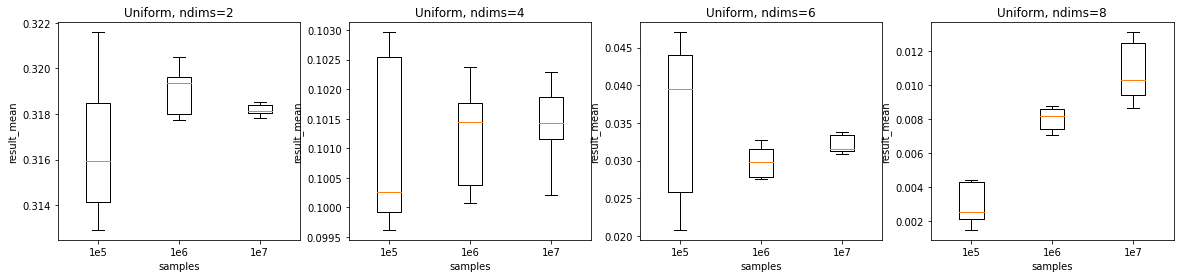

In [59]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    # ax.axhline(y=target, linestyle=':')
    ax.set_title(f'Uniform, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6', '1e7'], showfliers=False)

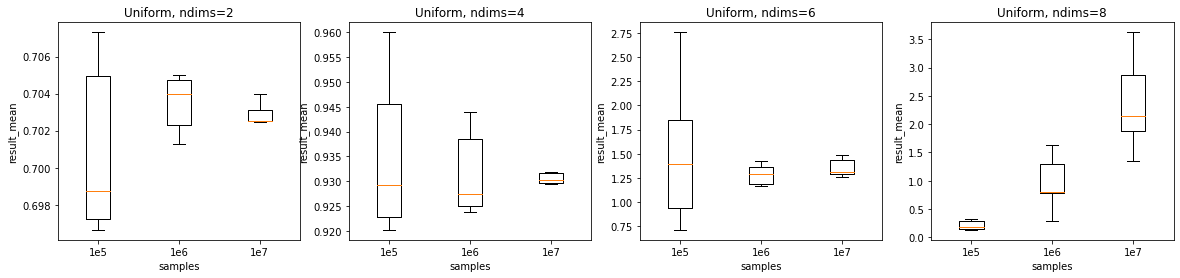

In [60]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Uniform, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6', '1e7'], showfliers=False)

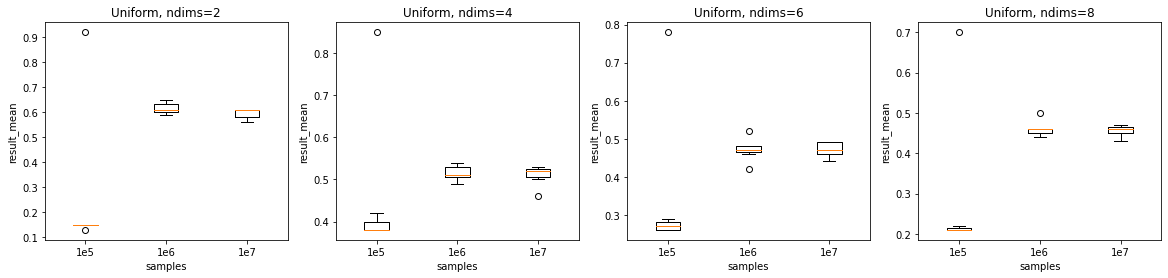

In [61]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Uniform, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6', '1e7'], showfliers=None)

#### Halton

##### simple

In [62]:
%%time
tf.random.set_seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [1e5, 1e6]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand = dim2func_dict[ndims]
        for neval in neval_lst:

            print(f'ndims={ndims}  nitn={neval}')

            time_a = time.time()
            data = tfp.mcmc.sample_halton_sequence(
                dim=ndims,
                #sequence_indices=sequence_indices,
                num_results=neval,
                dtype=tf.float64,
                randomized=True,
                seed=run
            )
            gen_time = time.time() - time_a
            
            time_a = time.time()
            current_result = integrand(data)
            current_result_mean = tf.reduce_mean(current_result)
            current_result_sdev = tf.math.reduce_std(current_result) / np.sqrt(ndims)
            eval_time = time.time() - time_a
            
            result_means.append(current_result_mean.numpy())
            result_sdevs.append(current_result_sdev.numpy())
            result_gen_times.append(gen_time)
            result_eval_times.append(eval_time)
            result_run_nums.append(run)
            
            # print(current_result_mean, current_result_stddev)

run=1
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=2
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=3
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=4
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=5
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=6
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=1000

In [63]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst) * len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
    # 'batch_num': result_jbatch
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)

In [64]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,eval_time_perc
0,2,100000,0.318408,0.703104,0.125664,0.018949,1,0.13
1,2,1000000,0.318309,0.702931,0.774927,0.023937,1,0.03
2,4,100000,0.100451,0.921665,0.137631,0.010971,1,0.07
3,4,1000000,0.101270,0.923835,1.578778,0.032912,1,0.02
4,6,100000,0.034305,1.363472,0.218415,0.013963,1,0.06
5,6,1000000,0.031978,1.407832,2.449450,0.042885,1,0.02
6,8,100000,0.001284,0.071509,0.293216,0.013963,1,0.05
7,8,1000000,0.006241,0.874641,3.240335,0.050864,1,0.02
8,2,100000,0.318307,0.702814,0.079786,0.003989,2,0.05
9,2,1000000,0.318298,0.702898,0.783904,0.023936,2,0.03


In [65]:
temp_df.to_csv('result/02_Baseline_LDSeq/f2_halton_simple.csv', index=False)

In [66]:
# pd.read_csv('result/02_Baseline_LDSeq/f2_halton_simple.csv')

In [67]:
g_temp_df = temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'eval_time_perc']]

In [68]:
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,eval_time_perc
0,2,100000,0.318250,0.702786,0.081069,0.005414,0.054286
1,2,1000000,0.318310,0.702923,0.779059,0.023651,0.030000
2,4,100000,0.101627,0.931040,0.142191,0.004987,0.034286
3,4,1000000,0.101258,0.928575,1.587184,0.034479,0.020000
4,6,100000,0.036397,1.386064,0.216279,0.006697,0.030000
5,6,1000000,0.031931,1.373243,2.427935,0.043028,0.020000
6,8,100000,0.003025,0.207515,0.291079,0.007124,0.024286
7,8,1000000,0.008576,1.302962,3.235633,0.052431,0.020000


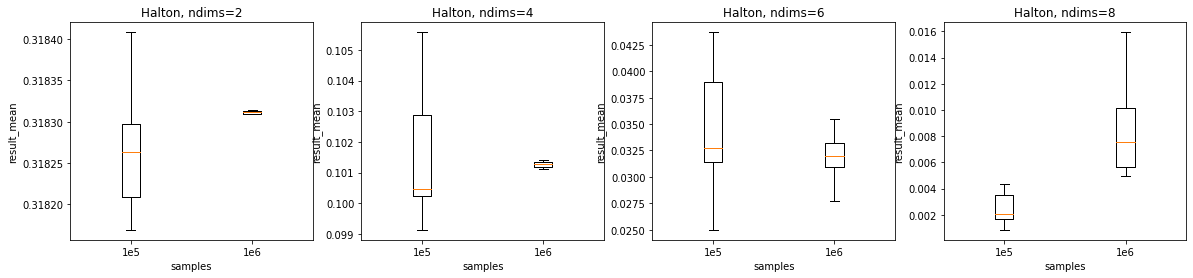

In [69]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    # ax.axhline(y=target, linestyle=':')
    ax.set_title(f'Halton, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=False)

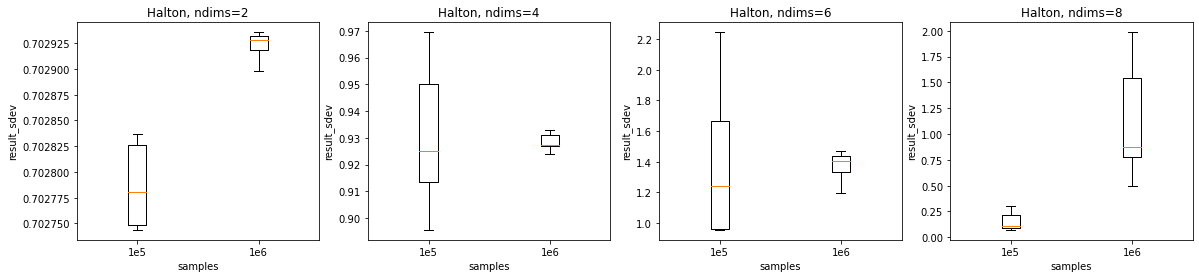

In [70]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Halton, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_sdev')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=False)

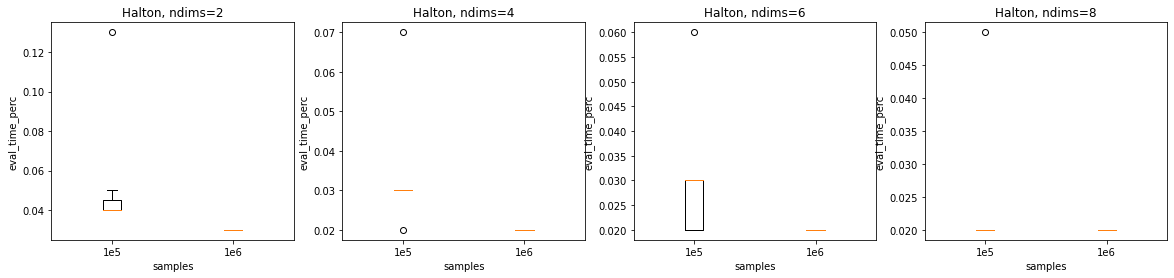

In [71]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Halton, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('eval_time_perc')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=None)

##### batch (kind of)

In [72]:
%%time
tf.random.set_seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []
result_jbatch = []

nbatch = 10
ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [1e6, 1e7]))
neval_on_batch = [x // nbatch for x in neval_lst]
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand = dim2func_dict[ndims]
        for i_eval, neval in enumerate(neval_lst):

            for j_batch in range(nbatch):
                print(f'ndims={ndims}  neval={neval}  j_batch={j_batch}')

                time_a = time.time()
                data = tfp.mcmc.sample_halton_sequence(
                    dim=ndims,
                    sequence_indices=tf.range(start=j_batch*neval_on_batch[i_eval],
                                              limit=(j_batch+1)*neval_on_batch[i_eval],
                                              dtype=tf.int32),
                    # num_results=nitn,
                    dtype=tf.float64,
                    randomized=True,
                    seed=run
                )
                gen_time = time.time() - time_a

                time_a = time.time()
                current_result = integrand(data)
                current_result_mean = tf.reduce_mean(current_result)
                current_result_sdev = tf.math.reduce_std(current_result) / np.sqrt(ndims)
                eval_time = time.time() - time_a

                result_means.append(current_result_mean.numpy())
                result_sdevs.append(current_result_sdev.numpy())
                result_gen_times.append(gen_time)
                result_eval_times.append(eval_time)
                result_run_nums.append(run)
                
                result_jbatch.append(j_batch)

                # print(current_result_mean, current_result_stddev)

run=1
ndims=2  neval=1000000  j_batch=0
ndims=2  neval=1000000  j_batch=1
ndims=2  neval=1000000  j_batch=2
ndims=2  neval=1000000  j_batch=3
ndims=2  neval=1000000  j_batch=4
ndims=2  neval=1000000  j_batch=5
ndims=2  neval=1000000  j_batch=6
ndims=2  neval=1000000  j_batch=7
ndims=2  neval=1000000  j_batch=8
ndims=2  neval=1000000  j_batch=9
ndims=2  neval=10000000  j_batch=0
ndims=2  neval=10000000  j_batch=1
ndims=2  neval=10000000  j_batch=2
ndims=2  neval=10000000  j_batch=3
ndims=2  neval=10000000  j_batch=4
ndims=2  neval=10000000  j_batch=5
ndims=2  neval=10000000  j_batch=6
ndims=2  neval=10000000  j_batch=7
ndims=2  neval=10000000  j_batch=8
ndims=2  neval=10000000  j_batch=9
ndims=4  neval=1000000  j_batch=0
ndims=4  neval=1000000  j_batch=1
ndims=4  neval=1000000  j_batch=2
ndims=4  neval=1000000  j_batch=3
ndims=4  neval=1000000  j_batch=4
ndims=4  neval=1000000  j_batch=5
ndims=4  neval=1000000  j_batch=6
ndims=4  neval=1000000  j_batch=7
ndims=4  neval=1000000  j_batch=

ndims=8  neval=10000000  j_batch=7
ndims=8  neval=10000000  j_batch=8
ndims=8  neval=10000000  j_batch=9
run=4
ndims=2  neval=1000000  j_batch=0
ndims=2  neval=1000000  j_batch=1
ndims=2  neval=1000000  j_batch=2
ndims=2  neval=1000000  j_batch=3
ndims=2  neval=1000000  j_batch=4
ndims=2  neval=1000000  j_batch=5
ndims=2  neval=1000000  j_batch=6
ndims=2  neval=1000000  j_batch=7
ndims=2  neval=1000000  j_batch=8
ndims=2  neval=1000000  j_batch=9
ndims=2  neval=10000000  j_batch=0
ndims=2  neval=10000000  j_batch=1
ndims=2  neval=10000000  j_batch=2
ndims=2  neval=10000000  j_batch=3
ndims=2  neval=10000000  j_batch=4
ndims=2  neval=10000000  j_batch=5
ndims=2  neval=10000000  j_batch=6
ndims=2  neval=10000000  j_batch=7
ndims=2  neval=10000000  j_batch=8
ndims=2  neval=10000000  j_batch=9
ndims=4  neval=1000000  j_batch=0
ndims=4  neval=1000000  j_batch=1
ndims=4  neval=1000000  j_batch=2
ndims=4  neval=1000000  j_batch=3
ndims=4  neval=1000000  j_batch=4
ndims=4  neval=1000000  j_bat

ndims=8  neval=10000000  j_batch=4
ndims=8  neval=10000000  j_batch=5
ndims=8  neval=10000000  j_batch=6
ndims=8  neval=10000000  j_batch=7
ndims=8  neval=10000000  j_batch=8
ndims=8  neval=10000000  j_batch=9
run=7
ndims=2  neval=1000000  j_batch=0
ndims=2  neval=1000000  j_batch=1
ndims=2  neval=1000000  j_batch=2
ndims=2  neval=1000000  j_batch=3
ndims=2  neval=1000000  j_batch=4
ndims=2  neval=1000000  j_batch=5
ndims=2  neval=1000000  j_batch=6
ndims=2  neval=1000000  j_batch=7
ndims=2  neval=1000000  j_batch=8
ndims=2  neval=1000000  j_batch=9
ndims=2  neval=10000000  j_batch=0
ndims=2  neval=10000000  j_batch=1
ndims=2  neval=10000000  j_batch=2
ndims=2  neval=10000000  j_batch=3
ndims=2  neval=10000000  j_batch=4
ndims=2  neval=10000000  j_batch=5
ndims=2  neval=10000000  j_batch=6
ndims=2  neval=10000000  j_batch=7
ndims=2  neval=10000000  j_batch=8
ndims=2  neval=10000000  j_batch=9
ndims=4  neval=1000000  j_batch=0
ndims=4  neval=1000000  j_batch=1
ndims=4  neval=1000000  j_

In [73]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * nbatch * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst * nbatch)* len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
    'batch_num': result_jbatch
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)

In [74]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,batch_num,eval_time_perc
0,2,1000000,0.318408,0.703104,0.076793,0.010971,1,0,0.13
1,2,1000000,0.318348,0.702962,0.075798,0.001994,1,1,0.03
2,2,1000000,0.318299,0.702869,0.082780,0.002991,1,2,0.03
3,2,1000000,0.318324,0.703020,0.083776,0.002992,1,3,0.03
4,2,1000000,0.318349,0.703109,0.077792,0.002992,1,4,0.04
...,...,...,...,...,...,...,...,...,...
555,8,10000000,0.019810,3.442241,3.696116,0.051861,7,5,0.01
556,8,10000000,0.011408,2.070994,3.663204,0.060838,7,6,0.02
557,8,10000000,0.012108,2.045566,3.694121,0.051862,7,7,0.01
558,8,10000000,0.003957,0.315423,3.845716,0.050864,7,8,0.01


In [75]:
temp_df.to_csv('result/02_Baseline_LDSeq/f2_halton_batch.csv', index=False)

In [76]:
# pd.read_csv('result/02_Baseline_LDSeq/f2_halton_batch.csv')

In [77]:
# mean over batches
g_temp_df = temp_df.groupby(['ndims', 'neval', 'run_num'], as_index=False).agg(np.mean)

# mean over runs
g_temp_df = g_temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'eval_time_perc']]
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,eval_time_perc
0,2,1000000,0.318292,0.702888,0.078775,0.002607,0.033143
1,2,10000000,0.318310,0.702920,0.856239,0.024663,0.030000
2,4,1000000,0.101656,0.934660,0.156880,0.003904,0.024571
3,4,10000000,0.101328,0.929819,1.771620,0.034864,0.020143
4,6,1000000,0.031674,1.250461,0.238519,0.004759,0.020714
5,6,10000000,0.032086,1.327716,2.689836,0.043555,0.017714
6,8,1000000,0.010394,0.973609,0.318890,0.005685,0.018429
7,8,10000000,0.009716,1.506549,3.618709,0.053372,0.013143


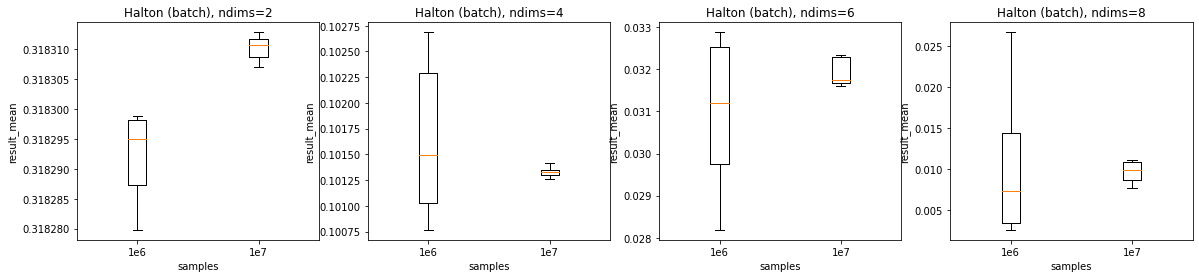

In [78]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims]\
        .groupby(['neval', 'run_num'], as_index=False).agg(np.mean)\
        .groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    # ax.axhline(y=target, linestyle=':')
    ax.set_title(f'Halton (batch), ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e6', '1e7'], showfliers=False)

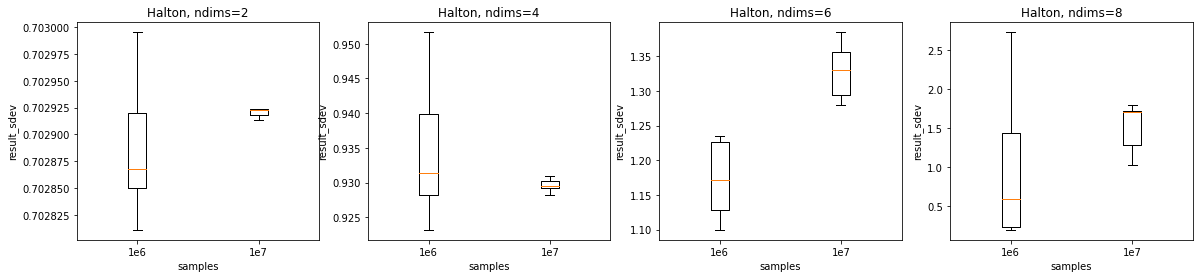

In [79]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims]\
        .groupby(['neval', 'run_num'], as_index=False).agg(np.mean)\
        .groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Halton, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_sdev')
    ax.boxplot(plot_data, labels=['1e6', '1e7'], showfliers=False)

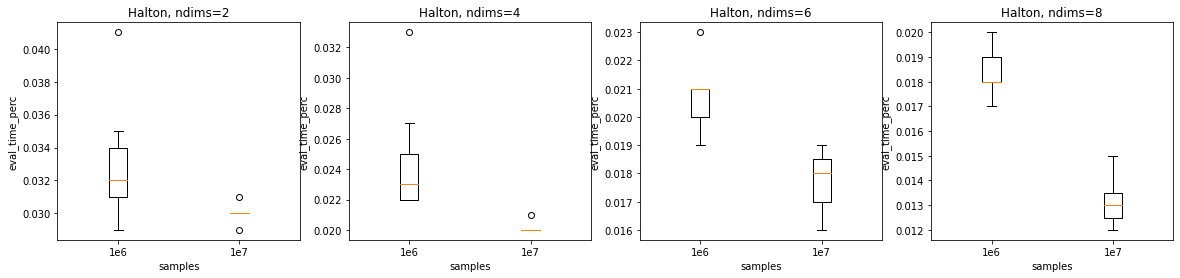

In [80]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims]\
        .groupby(['neval', 'run_num'], as_index=False).agg(np.mean)\
        .groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Halton, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('eval_time_perc')
    ax.boxplot(plot_data, labels=['1e6', '1e7'], showfliers=None)

#### Sobol

##### simple

In [81]:
%%time
tf.random.set_seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [1e5, 1e6]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand = dim2func_dict[ndims]
        for neval in neval_lst:

            print(f'ndims={ndims}  nitn={neval}')

            time_a = time.time()
            data = tf.math.sobol_sample(
                dim=ndims,
                num_results=neval,
                # skip=j*neval,
                dtype=tf.dtypes.float64,
                #name=None
            )
            gen_time = time.time() - time_a
            
            time_a = time.time()
            current_result = integrand(data)
            current_result_mean = tf.reduce_mean(current_result)
            current_result_sdev = tf.math.reduce_std(current_result) / np.sqrt(ndims)
            eval_time = time.time() - time_a
            
            result_means.append(current_result_mean.numpy())
            result_sdevs.append(current_result_sdev.numpy())
            result_gen_times.append(gen_time)
            result_eval_times.append(eval_time)
            result_run_nums.append(run)
            
            # print(current_result_mean, current_result_stddev)

run=1
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=2
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=3
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=4
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=5
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=6
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=1000

In [82]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst)* len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
    # 'batch_num': result_jbatch
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)

In [83]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,eval_time_perc
0,2,100000,0.318190,0.702801,0.008976,0.010970,1,0.55
1,2,1000000,0.318298,0.702893,0.001995,0.022939,1,0.92
2,4,100000,0.102388,0.927553,0.001994,0.012967,1,0.87
3,4,1000000,0.101423,0.933204,0.004985,0.033910,1,0.87
4,6,100000,0.039327,1.451471,0.002991,0.012966,1,0.81
5,6,1000000,0.032605,1.493749,0.004987,0.044880,1,0.90
6,8,100000,0.143419,14.901407,0.004987,0.013963,1,0.74
7,8,1000000,0.025584,5.192108,0.009974,0.054853,1,0.85
8,2,100000,0.318190,0.702801,0.005984,0.002992,2,0.33
9,2,1000000,0.318298,0.702893,0.001995,0.023936,2,0.92


In [84]:
temp_df.to_csv('result/02_Baseline_LDSeq/f2_sobol_simple.csv', index=False)

In [85]:
# pd.read_csv('result/02_Baseline_LDSeq/f2_sobol_simple.csv')

In [86]:
g_temp_df = temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'eval_time_perc']]

In [87]:
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,eval_time_perc
0,2,100000,0.318190,0.702801,0.006554,0.004417,0.377143
1,2,1000000,0.318298,0.702893,0.002280,0.024791,0.915714
2,4,100000,0.102388,0.927553,0.001995,0.005699,0.715714
3,4,1000000,0.101423,0.933204,0.004131,0.033910,0.890000
4,6,100000,0.039327,1.451471,0.003561,0.007124,0.644286
5,6,1000000,0.032605,1.493749,0.006269,0.044738,0.878571
6,8,100000,0.143419,14.901407,0.005272,0.007409,0.568571
7,8,1000000,0.025584,5.192108,0.009688,0.056136,0.854286


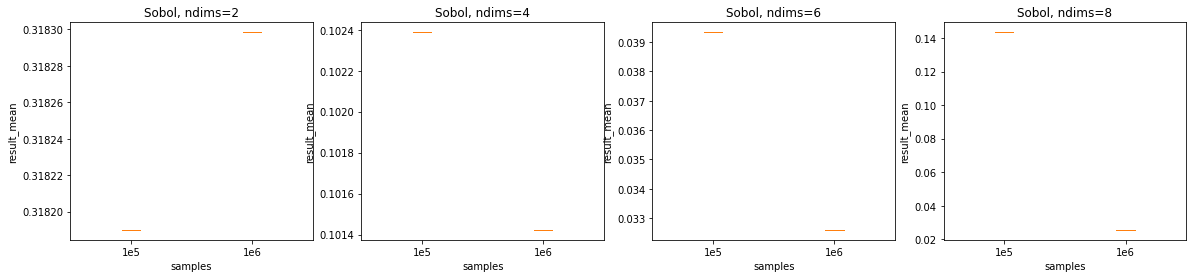

In [88]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    # ax.axhline(y=target, linestyle=':')
    ax.set_title(f'Sobol, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=False)

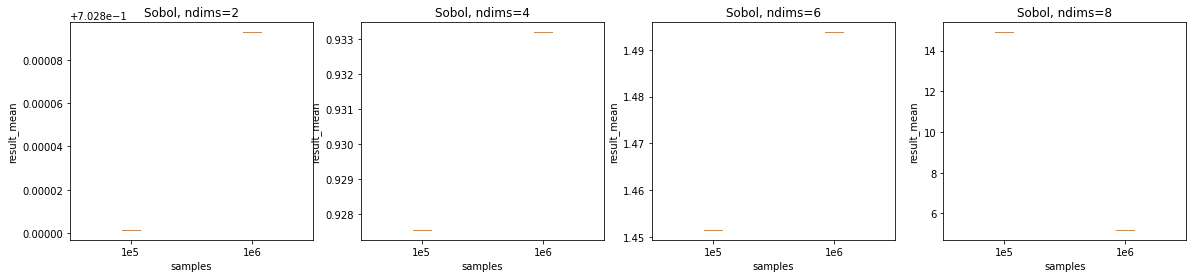

In [89]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Sobol, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=False)

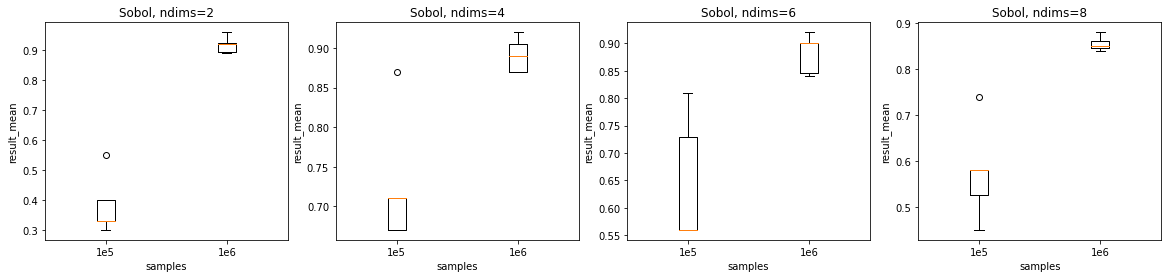

In [90]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Sobol, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=None)

### F3 - sin

In [173]:
{
    # from 0 to 10
    
    'f3_d2': 8 * np.cos(5) * np.sin(5) ** 3,    
    'f3_d4': 32 * (np.cos(5) + np.cos(15)) * np.sin(5) ** 5,
    'f3_d6': 128 * (np.cos(5) + np.cos(15) + np.cos(25)) * np.sin(5) ** 7,
    'f3_d8': 128 * (np.cos(35) - np.cos(45)) * np.sin(5) ** 7,
}

{'f3_d2': -2.000987472506367,
 'f3_d4': 12.350995604774042,
 'f3_d6': -49.165073816419444,
 'f3_d8': 136.37560840041465}

In [174]:
@tf.function(input_signature=[tf.TensorSpec(shape=(None,2), dtype=tf.float64)])
def f3_d2(x):
    return tf.sin(tf.reduce_sum(x, axis=-1))

def f3_d2_np(x):
    return np.sin(np.sum(x, axis=-1))


@tf.function(input_signature=[tf.TensorSpec(shape=(None,4), dtype=tf.float64)])
def f3_d4(x):
    return tf.sin(tf.reduce_sum(x, axis=-1))


@tf.function(input_signature=[tf.TensorSpec(shape=(None,6), dtype=tf.float64)])
def f3_d6(x):
    return tf.sin(tf.reduce_sum(x, axis=-1))


@tf.function(input_signature=[tf.TensorSpec(shape=(None,8), dtype=tf.float64)])
def f3_d8(x):
    return tf.sin(tf.reduce_sum(x, axis=-1))

In [175]:
dim2func_dict = {
    2: f3_d2,
    4: f3_d4,
    6: f3_d6,
    8: f3_d8,
}
dim2func_dict

{2: <tensorflow.python.eager.def_function.Function at 0x1788730d548>,
 4: <tensorflow.python.eager.def_function.Function at 0x178cfdbcb08>,
 6: <tensorflow.python.eager.def_function.Function at 0x1788054aa08>,
 8: <tensorflow.python.eager.def_function.Function at 0x178cfdbc948>}

#### Uniform

In [94]:
%%time
tf.random.set_seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [1e5, 1e6, 1e7]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand = dim2func_dict[ndims]
        for neval in neval_lst:

            print(f'ndims={ndims}  nitn={neval}')

            time_a = time.time()
            data = tf.random.uniform(shape=(neval, ndims), minval=0, maxval=10, dtype=tf.float64)
            gen_time = time.time() - time_a
            
            time_a = time.time()
            current_result = integrand(data)
            current_result_mean = tf.reduce_mean(current_result)
            current_result_sdev = tf.math.reduce_std(current_result) / np.sqrt(ndims)
            eval_time = time.time() - time_a
            
            result_means.append(current_result_mean.numpy())
            result_sdevs.append(current_result_sdev.numpy())
            result_gen_times.append(gen_time)
            result_eval_times.append(eval_time)
            result_run_nums.append(run)
            
            # print(current_result_mean, current_result_stddev)

run=1
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=2  nitn=10000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=4  nitn=10000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=6  nitn=10000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
ndims=8  nitn=10000000
run=2
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=2  nitn=10000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=4  nitn=10000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=6  nitn=10000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
ndims=8  nitn=10000000
run=3
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=2  nitn=10000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=4  nitn=10000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=6  nitn=10000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
ndims=8  nitn=10000000
run=4
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=2  nitn=10000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=4  nitn=10000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=6  

In [95]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst)* len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
    # 'batch_num': result_jbatch
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)

In [96]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,eval_time_perc
0,2,100000,-0.020441,0.499394,0.007979,0.031915,1,0.80
1,2,1000000,-0.020094,0.499392,0.019946,0.007979,1,0.29
2,2,10000000,-0.020253,0.499506,0.197474,0.078788,1,0.29
3,4,100000,0.003997,0.354125,0.017952,0.040890,1,0.69
4,4,1000000,0.001765,0.353577,0.039893,0.009974,1,0.20
...,...,...,...,...,...,...,...,...
79,6,1000000,-0.000033,0.288698,0.064827,0.009973,7,0.13
80,6,10000000,0.000268,0.288647,0.595408,0.090757,7,0.13
81,8,100000,0.000359,0.250051,0.043883,0.007978,7,0.15
82,8,1000000,-0.000418,0.250086,0.079787,0.009973,7,0.11


In [97]:
temp_df.to_csv('result/02_Baseline_LDSeq/f3_uniform.csv', index=False)

In [98]:
# pd.read_csv('result/02_Baseline_LDSeq/f3_uniform.csv')

In [99]:
g_temp_df = temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'eval_time_perc']]

In [100]:
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,eval_time_perc
0,2,100000,-0.018861,0.499652,0.045877,0.011256,0.224286
1,2,1000000,-0.020543,0.499416,0.019234,0.008121,0.300000
2,2,10000000,-0.020148,0.499531,0.199182,0.081496,0.291429
3,4,100000,0.002367,0.353688,0.016955,0.012680,0.374286
4,4,1000000,0.001132,0.353532,0.038753,0.009404,0.195714
5,4,10000000,0.001174,0.353561,0.396226,0.083633,0.174286
6,6,100000,-0.001124,0.288770,0.033339,0.012538,0.244286
7,6,1000000,-0.000088,0.288669,0.058273,0.009688,0.141429
8,6,10000000,0.000150,0.288670,0.587287,0.092610,0.137143
9,8,100000,0.000685,0.249867,0.045877,0.012395,0.190000


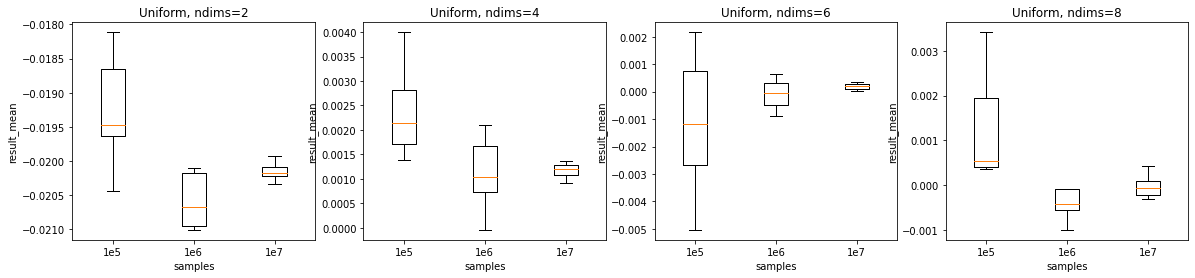

In [101]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    # ax.axhline(y=target, linestyle=':')
    ax.set_title(f'Uniform, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6', '1e7'], showfliers=False)

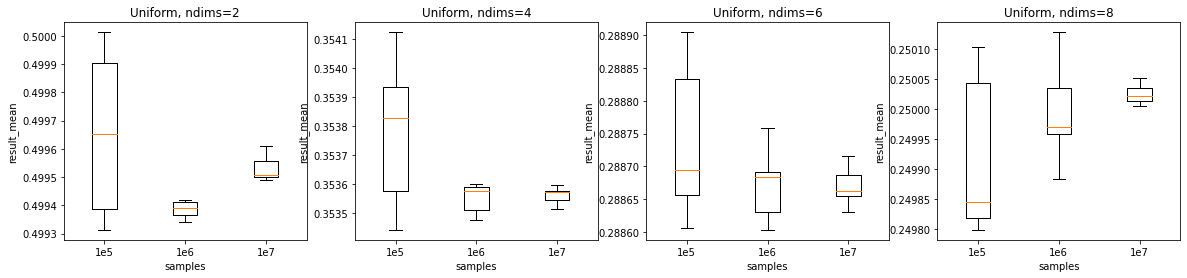

In [102]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Uniform, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6', '1e7'], showfliers=False)

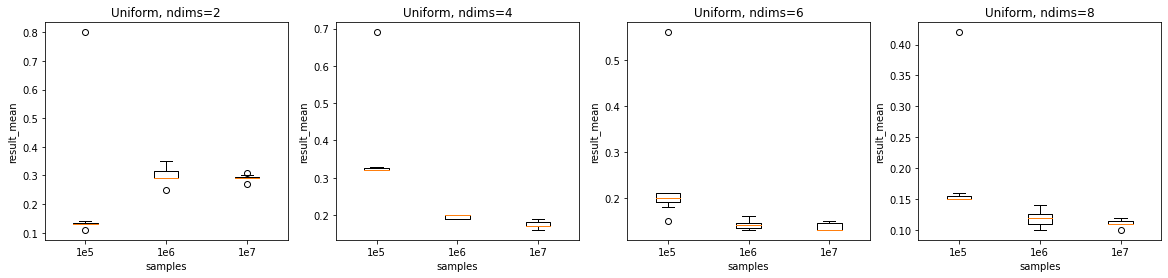

In [103]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Uniform, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6', '1e7'], showfliers=None)

#### Halton

##### simple

In [104]:
%%time
tf.random.set_seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [1e5, 1e6]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand = dim2func_dict[ndims]
        for neval in neval_lst:

            print(f'ndims={ndims}  nitn={neval}')

            time_a = time.time()
            data = tfp.mcmc.sample_halton_sequence(
                dim=ndims,
                #sequence_indices=sequence_indices,
                num_results=neval,
                dtype=tf.float64,
                randomized=True,
                seed=run
            ) * 10
            gen_time = time.time() - time_a
            
            V = 10 ** ndims
            
            time_a = time.time()
            current_result = integrand(data)
            current_result_mean = tf.reduce_mean(current_result) * V
            current_result_sdev = tf.math.reduce_std(current_result) * V / np.sqrt(ndims)
            eval_time = time.time() - time_a
            
            result_means.append(current_result_mean.numpy())
            result_sdevs.append(current_result_sdev.numpy())
            result_gen_times.append(gen_time)
            result_eval_times.append(eval_time)
            result_run_nums.append(run)
            
            # print(current_result_mean, current_result_stddev)

run=1
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=2
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=3
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=4
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=5
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=6
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=1000

In [105]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst) * len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
    # 'batch_num': result_jbatch
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)

In [106]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,eval_time_perc
0,2,100000,-1.997850,4.995059e+01,0.125664,0.010971,1,0.08
1,2,1000000,-2.001000,4.994970e+01,0.763956,0.007979,1,0.01
2,4,100000,14.791728,3.532576e+03,0.136635,0.003989,1,0.03
3,4,1000000,11.803502,3.535585e+03,1.569802,0.008976,1,0.01
4,6,100000,718.132925,2.890150e+05,0.213429,0.004987,1,0.02
5,6,1000000,-341.375240,2.886727e+05,2.436485,0.009973,1,0.00
6,8,100000,169444.802735,2.496883e+07,0.286235,0.003989,1,0.01
7,8,1000000,59669.097067,2.499165e+07,3.236346,0.011968,1,0.00
8,2,100000,-2.000221,4.994960e+01,0.071808,0.001995,2,0.03
9,2,1000000,-2.001089,4.994980e+01,0.766949,0.008976,2,0.01


In [107]:
temp_df.to_csv('result/02_Baseline_LDSeq/f3_halton_simple.csv', index=False)

In [108]:
# pd.read_csv('result/02_Baseline_LDSeq/f3_halton_simple.csv')

In [109]:
g_temp_df = temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'eval_time_perc']]

In [110]:
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,eval_time_perc
0,2,100000,-2.002110,4.994984e+01,0.083776,0.003277,0.034286
1,2,1000000,-2.001185,4.994979e+01,0.769086,0.008263,0.010000
2,4,100000,11.891500,3.535460e+03,0.140766,0.002422,0.014286
3,4,1000000,12.366522,3.535559e+03,1.582198,0.009403,0.010000
4,6,100000,-539.328878,2.890672e+05,0.222975,0.002565,0.011429
5,6,1000000,-316.138584,2.887001e+05,2.408417,0.010258,0.000000
6,8,100000,108907.741976,2.499325e+07,0.290794,0.002280,0.010000
7,8,1000000,-3886.061942,2.499328e+07,3.229649,0.010828,0.000000


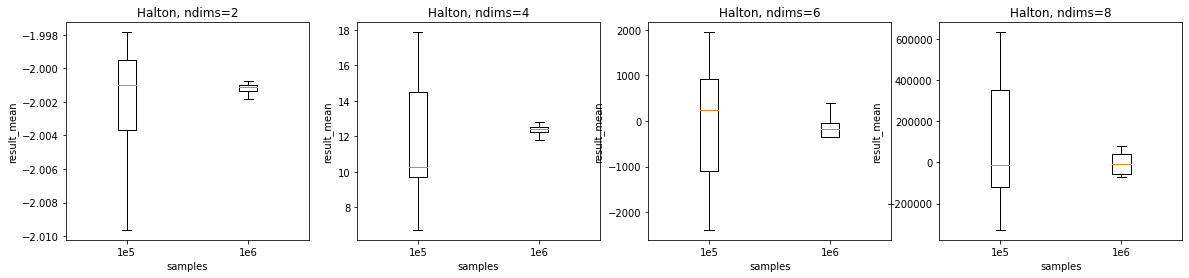

In [111]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    # ax.axhline(y=target, linestyle=':')
    ax.set_title(f'Halton, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=False)

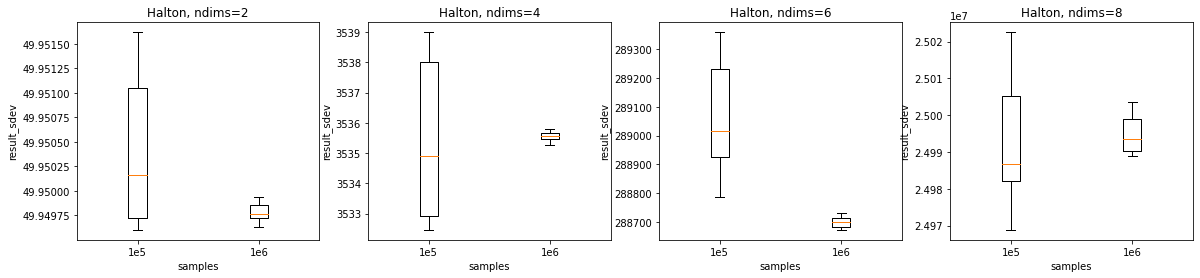

In [112]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Halton, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_sdev')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=False)

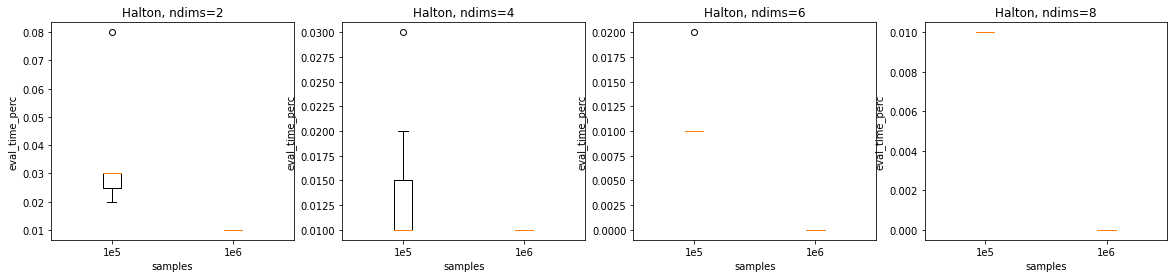

In [113]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Halton, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('eval_time_perc')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=None)

##### batch (kind of)

In [114]:
%%time
tf.random.set_seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []
result_jbatch = []

nbatch = 10
ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [1e6, 1e7]))
neval_on_batch = [x // nbatch for x in neval_lst]
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand = dim2func_dict[ndims]
        for i_eval, neval in enumerate(neval_lst):

            for j_batch in range(nbatch):
                print(f'ndims={ndims}  neval={neval}  j_batch={j_batch}')

                time_a = time.time()
                data = tfp.mcmc.sample_halton_sequence(
                    dim=ndims,
                    sequence_indices=tf.range(start=j_batch*neval_on_batch[i_eval],
                                              limit=(j_batch+1)*neval_on_batch[i_eval],
                                              dtype=tf.int32),
                    # num_results=nitn,
                    dtype=tf.float64,
                    randomized=True,
                    seed=run
                ) * 10
                gen_time = time.time() - time_a
                
                V = 10 ** ndims

                time_a = time.time()
                current_result = integrand(data)
                current_result_mean = tf.reduce_mean(current_result) * V
                current_result_sdev = tf.math.reduce_std(current_result) * V / np.sqrt(ndims)
                eval_time = time.time() - time_a

                result_means.append(current_result_mean.numpy())
                result_sdevs.append(current_result_sdev.numpy())
                result_gen_times.append(gen_time)
                result_eval_times.append(eval_time)
                result_run_nums.append(run)
                
                result_jbatch.append(j_batch)

                # print(current_result_mean, current_result_stddev)

run=1
ndims=2  neval=1000000  j_batch=0
ndims=2  neval=1000000  j_batch=1
ndims=2  neval=1000000  j_batch=2
ndims=2  neval=1000000  j_batch=3
ndims=2  neval=1000000  j_batch=4
ndims=2  neval=1000000  j_batch=5
ndims=2  neval=1000000  j_batch=6
ndims=2  neval=1000000  j_batch=7
ndims=2  neval=1000000  j_batch=8
ndims=2  neval=1000000  j_batch=9
ndims=2  neval=10000000  j_batch=0
ndims=2  neval=10000000  j_batch=1
ndims=2  neval=10000000  j_batch=2
ndims=2  neval=10000000  j_batch=3
ndims=2  neval=10000000  j_batch=4
ndims=2  neval=10000000  j_batch=5
ndims=2  neval=10000000  j_batch=6
ndims=2  neval=10000000  j_batch=7
ndims=2  neval=10000000  j_batch=8
ndims=2  neval=10000000  j_batch=9
ndims=4  neval=1000000  j_batch=0
ndims=4  neval=1000000  j_batch=1
ndims=4  neval=1000000  j_batch=2
ndims=4  neval=1000000  j_batch=3
ndims=4  neval=1000000  j_batch=4
ndims=4  neval=1000000  j_batch=5
ndims=4  neval=1000000  j_batch=6
ndims=4  neval=1000000  j_batch=7
ndims=4  neval=1000000  j_batch=

ndims=8  neval=10000000  j_batch=7
ndims=8  neval=10000000  j_batch=8
ndims=8  neval=10000000  j_batch=9
run=4
ndims=2  neval=1000000  j_batch=0
ndims=2  neval=1000000  j_batch=1
ndims=2  neval=1000000  j_batch=2
ndims=2  neval=1000000  j_batch=3
ndims=2  neval=1000000  j_batch=4
ndims=2  neval=1000000  j_batch=5
ndims=2  neval=1000000  j_batch=6
ndims=2  neval=1000000  j_batch=7
ndims=2  neval=1000000  j_batch=8
ndims=2  neval=1000000  j_batch=9
ndims=2  neval=10000000  j_batch=0
ndims=2  neval=10000000  j_batch=1
ndims=2  neval=10000000  j_batch=2
ndims=2  neval=10000000  j_batch=3
ndims=2  neval=10000000  j_batch=4
ndims=2  neval=10000000  j_batch=5
ndims=2  neval=10000000  j_batch=6
ndims=2  neval=10000000  j_batch=7
ndims=2  neval=10000000  j_batch=8
ndims=2  neval=10000000  j_batch=9
ndims=4  neval=1000000  j_batch=0
ndims=4  neval=1000000  j_batch=1
ndims=4  neval=1000000  j_batch=2
ndims=4  neval=1000000  j_batch=3
ndims=4  neval=1000000  j_batch=4
ndims=4  neval=1000000  j_bat

ndims=8  neval=10000000  j_batch=4
ndims=8  neval=10000000  j_batch=5
ndims=8  neval=10000000  j_batch=6
ndims=8  neval=10000000  j_batch=7
ndims=8  neval=10000000  j_batch=8
ndims=8  neval=10000000  j_batch=9
run=7
ndims=2  neval=1000000  j_batch=0
ndims=2  neval=1000000  j_batch=1
ndims=2  neval=1000000  j_batch=2
ndims=2  neval=1000000  j_batch=3
ndims=2  neval=1000000  j_batch=4
ndims=2  neval=1000000  j_batch=5
ndims=2  neval=1000000  j_batch=6
ndims=2  neval=1000000  j_batch=7
ndims=2  neval=1000000  j_batch=8
ndims=2  neval=1000000  j_batch=9
ndims=2  neval=10000000  j_batch=0
ndims=2  neval=10000000  j_batch=1
ndims=2  neval=10000000  j_batch=2
ndims=2  neval=10000000  j_batch=3
ndims=2  neval=10000000  j_batch=4
ndims=2  neval=10000000  j_batch=5
ndims=2  neval=10000000  j_batch=6
ndims=2  neval=10000000  j_batch=7
ndims=2  neval=10000000  j_batch=8
ndims=2  neval=10000000  j_batch=9
ndims=4  neval=1000000  j_batch=0
ndims=4  neval=1000000  j_batch=1
ndims=4  neval=1000000  j_

In [115]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * nbatch * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst * nbatch)* len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
    'batch_num': result_jbatch
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)

In [116]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,batch_num,eval_time_perc
0,2,1000000,-1.997850,4.995059e+01,0.074799,0.003989,1,0,0.05
1,2,1000000,-2.006397,4.994974e+01,0.071808,0.000998,1,1,0.01
2,2,1000000,-2.006872,4.995030e+01,0.074800,0.001994,1,2,0.03
3,2,1000000,-2.000380,4.995292e+01,0.073803,0.001995,1,3,0.03
4,2,1000000,-1.997186,4.995035e+01,0.076795,0.000998,1,4,0.01
...,...,...,...,...,...,...,...,...,...
555,8,10000000,-116630.658394,2.500043e+07,3.691130,0.010971,7,5,0.00
556,8,10000000,-29715.244470,2.499097e+07,3.729028,0.011969,7,6,0.00
557,8,10000000,-45814.927273,2.499655e+07,3.721050,0.010971,7,7,0.00
558,8,10000000,32427.475337,2.499480e+07,3.828762,0.011968,7,8,0.00


In [117]:
temp_df.to_csv('result/02_Baseline_LDSeq/f3_halton_batch.csv', index=False)

In [118]:
# pd.read_csv('result/02_Baseline_LDSeq/f3_halton_batch.csv')

In [119]:
# mean over batches
g_temp_df = temp_df.groupby(['ndims', 'neval', 'run_num'], as_index=False).agg(np.mean)

# mean over runs
g_temp_df = g_temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'eval_time_perc']]
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,eval_time_perc
0,2,1000000,-2.001448,4.994983e+01,0.078746,0.001297,0.014714
1,2,10000000,-2.000984,4.994976e+01,0.862038,0.009104,0.010143
2,4,1000000,12.067543,3.535427e+03,0.158875,0.001440,0.010429
3,4,10000000,12.237545,3.535584e+03,1.785011,0.009945,0.009143
4,6,1000000,-187.753768,2.887025e+05,0.241241,0.001553,0.005000
5,6,10000000,-86.086485,2.886672e+05,2.709127,0.010600,0.000286
6,8,1000000,35804.075965,2.500076e+07,0.322480,0.001567,0.005286
7,8,10000000,-4718.555744,2.499782e+07,3.633644,0.010999,0.000000


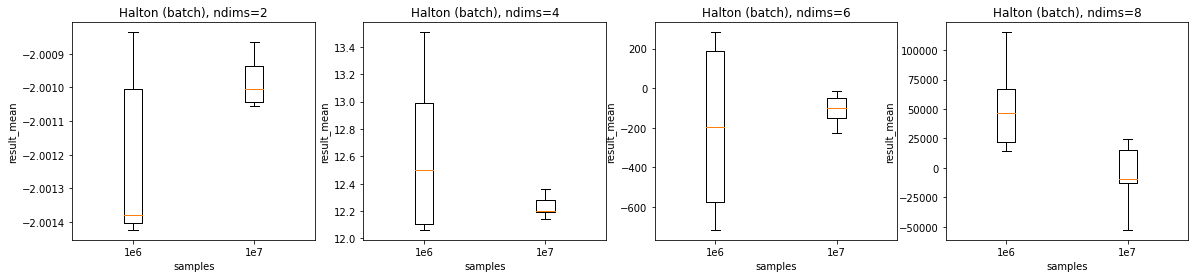

In [120]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims]\
        .groupby(['neval', 'run_num'], as_index=False).agg(np.mean)\
        .groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    # ax.axhline(y=target, linestyle=':')
    ax.set_title(f'Halton (batch), ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e6', '1e7'], showfliers=False)

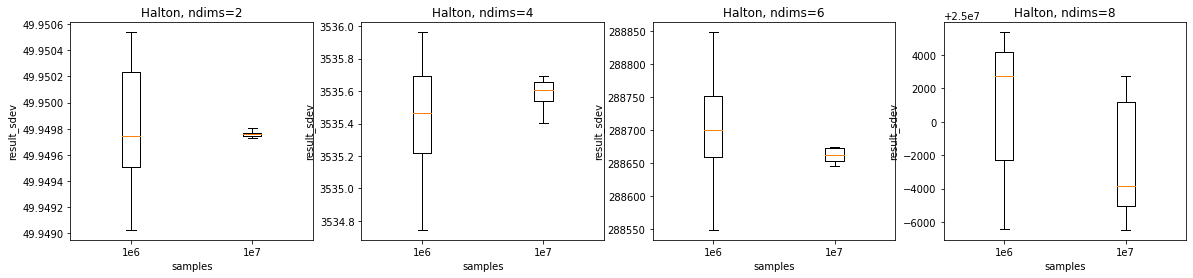

In [121]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims]\
        .groupby(['neval', 'run_num'], as_index=False).agg(np.mean)\
        .groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Halton, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_sdev')
    ax.boxplot(plot_data, labels=['1e6', '1e7'], showfliers=False)

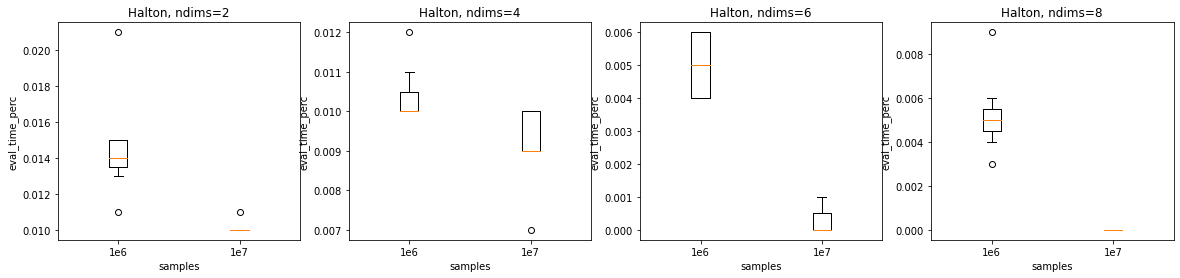

In [122]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims]\
        .groupby(['neval', 'run_num'], as_index=False).agg(np.mean)\
        .groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Halton, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('eval_time_perc')
    ax.boxplot(plot_data, labels=['1e6', '1e7'], showfliers=None)

#### Sobol

##### simple

In [177]:
data = tf.math.sobol_sample(
                dim=2,
                num_results=int(1e5),
                #skip=int(1e5),
                dtype=tf.dtypes.float64,
                #name=None
            ) * 10
data

<tf.Tensor: shape=(100000, 2), dtype=float64, numpy=
array([[5.        , 5.        ],
       [7.5       , 2.5       ],
       [2.5       , 7.5       ],
       ...,
       [5.45448303, 3.41957092],
       [0.45448303, 8.41957092],
       [0.61073303, 1.07582092]])>

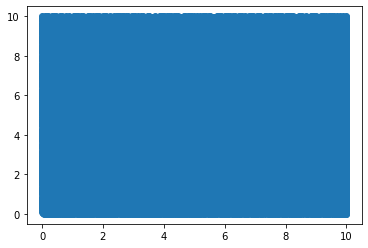

In [178]:
plt.scatter(data.numpy()[:,0], data.numpy()[:,1])

In [179]:
V = 100

In [180]:
current_result = dim2func_dict[2](data)
current_result_mean = tf.reduce_mean(current_result) * V
current_result_sdev = tf.math.reduce_std(current_result) * V / np.sqrt(ndims)

In [181]:
# np.std(current_result.numpy(), ddof=1) * V / np.sqrt(len(current_result))

In [182]:
tf.math.reduce_mean(current_result)

<tf.Tensor: shape=(), dtype=float64, numpy=-0.019940948384513667>

In [183]:
current_result_mean, current_result_sdev, tf.math.reduce_std(current_result) * V / np.sqrt(1e5)

(<tf.Tensor: shape=(), dtype=float64, numpy=-1.9940948384513668>,
 <tf.Tensor: shape=(), dtype=float64, numpy=24.97521794599794>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.22338514032049628>)

In [123]:
%%time
tf.random.set_seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []

ndims_lst = [2,4,6,8]
neval_lst = list(map(int, [1e5, 1e6]))
run_lst = list(range(1,NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand = dim2func_dict[ndims]
        for neval in neval_lst:

            print(f'ndims={ndims}  nitn={neval}')

            time_a = time.time()
            data = tf.math.sobol_sample(
                dim=ndims,
                num_results=neval,
                # skip=j*neval,
                dtype=tf.dtypes.float64,
                #name=None
            )
            gen_time = time.time() - time_a
            
            V = 10 ** ndims
            
            time_a = time.time()
            current_result = integrand(data)
            current_result_mean = tf.reduce_mean(current_result) * V
            current_result_sdev = tf.math.reduce_std(current_result) * V / np.sqrt(ndims)
            eval_time = time.time() - time_a
            
            result_means.append(current_result_mean.numpy())
            result_sdevs.append(current_result_sdev.numpy())
            result_gen_times.append(gen_time)
            result_eval_times.append(eval_time)
            result_run_nums.append(run)
            
            # print(current_result_mean, current_result_stddev)

run=1
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=2
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=3
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=4
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=5
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=100000
ndims=6  nitn=1000000
ndims=8  nitn=100000
ndims=8  nitn=1000000
run=6
ndims=2  nitn=100000
ndims=2  nitn=1000000
ndims=4  nitn=100000
ndims=4  nitn=1000000
ndims=6  nitn=1000

In [124]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst)* len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
    # 'batch_num': result_jbatch
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)

In [125]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,eval_time_perc
0,2,100000,7.736442e+01,1.562107e+01,0.006981,0.004987,1,0.42
1,2,1000000,7.736440e+01,1.562133e+01,0.002992,0.007979,1,0.73
2,4,100000,7.686260e+03,1.351501e+03,0.000997,0.004987,1,0.83
3,4,1000000,7.686201e+03,1.351695e+03,0.004987,0.009974,1,0.67
4,6,100000,1.096794e+05,2.300455e+05,0.003990,0.003989,1,0.50
5,6,1000000,1.096750e+05,2.300512e+05,0.006981,0.010970,1,0.61
6,8,100000,-5.407442e+07,1.681056e+07,0.004987,0.003989,1,0.44
7,8,1000000,-5.407408e+07,1.680312e+07,0.006981,0.010971,1,0.61
8,2,100000,7.736442e+01,1.562107e+01,0.004987,0.002992,2,0.38
9,2,1000000,7.736440e+01,1.562133e+01,0.001995,0.009974,2,0.83


In [126]:
temp_df.to_csv('result/02_Baseline_LDSeq/f3_sobol_simple.csv', index=False)

In [127]:
# pd.read_csv('result/02_Baseline_LDSeq/f3_sobol_simple.csv')

In [128]:
g_temp_df = temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'eval_time_perc']]

In [129]:
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,eval_time_perc
0,2,100000,7.736442e+01,1.562107e+01,0.005984,0.002422,0.281429
1,2,1000000,7.736440e+01,1.562133e+01,0.002279,0.008264,0.784286
2,4,100000,7.686260e+03,1.351501e+03,0.001709,0.002565,0.582857
3,4,1000000,7.686201e+03,1.351695e+03,0.003847,0.009404,0.712857
4,6,100000,1.096794e+05,2.300455e+05,0.003704,0.002422,0.388571
5,6,1000000,1.096750e+05,2.300512e+05,0.006839,0.009831,0.591429
6,8,100000,-5.407442e+07,1.681056e+07,0.004844,0.002423,0.331429
7,8,1000000,-5.407408e+07,1.680312e+07,0.008262,0.010971,0.571429


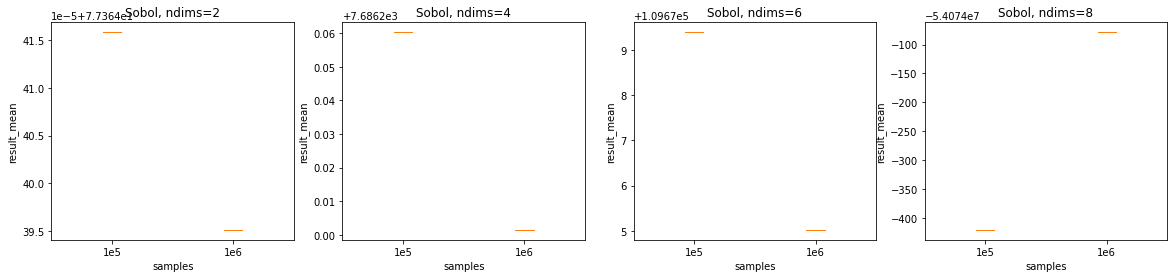

In [130]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    # ax.axhline(y=target, linestyle=':')
    ax.set_title(f'Sobol, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=False)

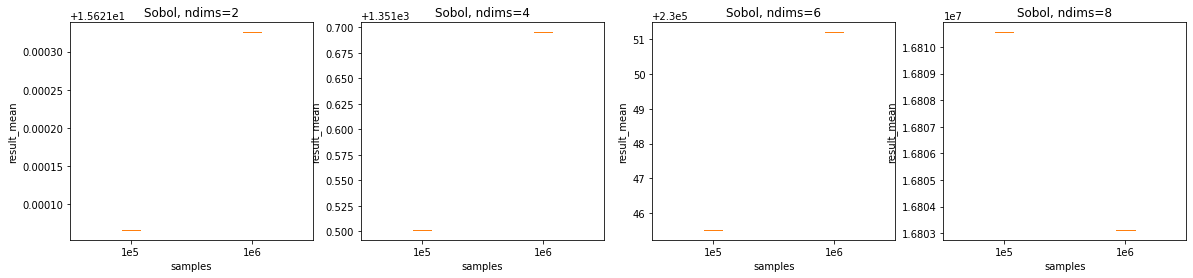

In [131]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Sobol, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=False)

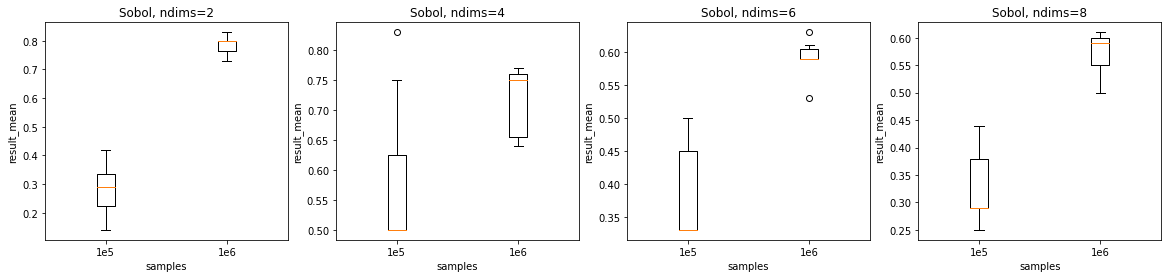

In [132]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(f'Sobol, ndims={ndims}')
    ax.set_xlabel('samples')
    ax.set_ylabel('result_mean')
    ax.boxplot(plot_data, labels=['1e5', '1e6'], showfliers=None)